In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytrends.request import TrendReq

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [66]:
X = pd.read_csv('AAPL_quarterly_financials.csv')
X.head()

,name,ttm,09/30/2023,06/30/2023,03/31/2023,12/31/2022,09/30/2022,06/30/2022,03/31/2022,12/31/2021,...,12/31/1987,09/30/1987,06/30/1987,03/31/1987,12/31/1986,09/30/1986,06/30/1986,03/31/1986,12/31/1985,09/30/1985
0,TotalRevenue,"383,285,000,000","89,498,000,000","81,797,000,000","94,836,000,000","117,154,000,000","90,146,000,000","82,959,000,000","97,278,000,000","123,945,000,000",...,"1,042,400,000","786,500,000","637,100,000","575,300,000","662,300,000","510,800,000","448,300,000","408,900,000","533,900,000","409,700,000"
1,\tOperatingRevenue,"383,285,000,000","89,498,000,000","81,797,000,000","94,836,000,000","117,154,000,000","90,146,000,000","82,959,000,000","97,278,000,000","123,945,000,000",...,"1,042,400,000","786,500,000","637,100,000","575,300,000","662,300,000","510,800,000","448,300,000","408,900,000","533,900,000","409,700,000"
2,CostOfRevenue,"214,137,000,000","49,071,000,000","45,384,000,000","52,860,000,000","66,822,000,000","52,051,000,000","47,074,000,000","54,719,000,000","69,702,000,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GrossProfit,"169,148,000,000","40,427,000,000","36,413,000,000","41,976,000,000","50,332,000,000","38,095,000,000","35,885,000,000","42,559,000,000","54,243,000,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OperatingExpense,"54,847,000,000","13,458,000,000","13,415,000,000","13,658,000,000","14,316,000,000","13,201,000,000","12,809,000,000","12,580,000,000","12,755,000,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
X.index = X.name

In [68]:
X = pd.DataFrame(X.loc['BasicEPS', :]).iloc[2:,:]
X.index = pd.to_datetime(X.index)
X = X.sort_index().fillna(0.)
X = X.loc["2004-03-31":]
X


,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


In [97]:
y = X.copy()
y

,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


# 3.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [100]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["App", "Steve Jobs", "IOS", "iPhone", "Tim Cook", "Camera", "rat", "Adele", "Makima"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [101]:
df

,App,Steve Jobs,IOS,iPhone,Tim Cook,Camera,rat,Adele,Makima
date,,,,,,,,,
2004-01-01,2,1,1,0,0,100,65,3,1
2004-02-01,2,1,1,0,2,68,64,3,0
2004-03-01,2,1,1,0,3,72,61,3,0
2004-04-01,2,1,1,0,1,74,67,3,0
2004-05-01,1,1,2,0,2,76,58,2,0
...,...,...,...,...,...,...,...,...,...
2023-09-01,83,2,21,66,26,51,69,7,32
2023-10-01,78,1,15,52,15,54,70,7,40
2023-11-01,76,1,13,49,14,51,74,7,31


In [102]:
df = df.resample('Q').mean()

In [103]:
df = df.loc[:"2023-09-30"]
df

,App,Steve Jobs,IOS,iPhone,Tim Cook,Camera,rat,Adele,Makima
date,,,,,,,,,
2004-03-31,2.000000,1.000000,1.000000,0.000000,1.666667,80.000000,63.333333,3.000000,0.333333
2004-06-30,1.333333,1.000000,1.666667,0.000000,1.666667,76.333333,63.000000,2.666667,0.000000
2004-09-30,1.333333,1.000000,1.333333,0.000000,3.333333,68.333333,62.333333,2.666667,0.000000
2004-12-31,2.000000,1.000000,1.000000,0.000000,1.666667,78.666667,66.000000,2.000000,0.333333
2005-03-31,1.666667,1.000000,1.000000,0.000000,2.666667,63.333333,61.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2022-09-30,80.333333,1.333333,19.333333,53.000000,14.000000,47.333333,68.333333,6.000000,21.333333
2022-12-31,76.666667,1.666667,16.000000,50.000000,18.333333,47.333333,67.666667,6.000000,91.666667
2023-03-31,78.000000,1.333333,13.333333,48.666667,13.333333,46.000000,66.333333,7.000000,59.666667


# 2.) Normalize all the X data

In [104]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# 1.) Import data. Train, Test, Holdout (80%,15%,5%)

In [105]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled,y, test_size = 0.2, random_state = 42)

X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 42)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [106]:
lasso = Lasso(alpha = .5)

In [107]:
lasso.fit(X_scaled, y)

Lasso(alpha=0.5)

In [114]:
coefficients = lasso.coef_
intercept = lasso.intercept_
print(coefficients)

[ 0.  0.  0.  0.  0. -0.  0.  0.  0.]


<function matplotlib.pyplot.show(close=None, block=None)>

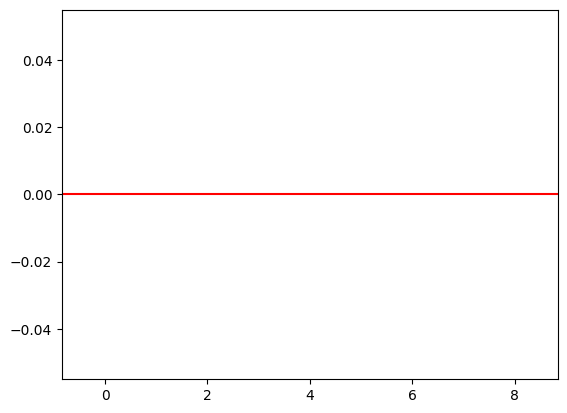

In [115]:
plt.bar(range(len(coefficients)), coefficients)
plt.axhline(0, color = 'red')
plt.show

# 5.) Do these coefficient magnitudes make sense?

These coefficient magnitidues do make sense. They all are zero. This implies that Google searches do not have a strong effect on stock price of Apple during this period of time. 

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?